In [27]:
using Pkg
Pkg.activate("validation")
Pkg.instantiate()

In [67]:
using CairoMakie
using FindSteadyStates
import RetroSignalModel as rs

In [36]:
rtgM4 = rs.rtgM4(1);
pr_table = rs.get_protein_lookup(model);

## Initiate protein concentrations

- Get expression levels: `getExpLevels` uses data from [GSE102475](https://github.com/NTUMitoLab/RetroSignalModel.jl?organization=NTUMitoLab&organization=NTUMitoLab#differential-gene-expression)
- Sampling agent concentrations: The [`init_u`](https://github.com/stevengogogo/RetroSignalModel.jl/blob/73ffb3713b8e5481a85c3ce9590c9c53e8440faf/src/models/utils.jl#L63-L85) can setup protein concentrations with given total expression levels.

In [44]:
# Set expression level
exp = rs.getExpLevels()
exp_dBmh = (exp..., Bmh=1e-4)

(Bmh = 0.0001, Rtg1 = 145.92035635681052, Rtg2 = 651.6543766184083, Rtg3 = 409.50361198825453, Mks = 267.49672022463335)

In [46]:
# Get agent concentrations
u_low = rs.init_u(rtgM4.model, pr_table; expLevels=exp_dBmh, init_s=0.2);

In [51]:
# Get solution
sol = rs.getSteadySol(rtgM4, u_low)

u: 17-element LabelledArrays.LArray{Float64, 1, Vector{Float64}, (:s, :Rtg2_ina_c, :Rtg2_act_c, :Mks, :Rtg2Mks_c, :Bmh, :BmhMks, :Rtg13_a_c, :Rtg13_i_c, :Rtg3_i_c, :Rtg3_a_c, :Rtg3_a_n, :Rtg3_i_n, :Rtg1_c, :Rtg1_n, :Rtg13_a_n, :Rtg13_i_n)}:
          :s => 0.2
 :Rtg2_ina_c => 384.61864901665916
 :Rtg2_act_c => 0.014881032712167588
        :Mks => 0.4758725061062714
  :Rtg2Mks_c => 267.02084656903645
        :Bmh => 9.88505097481813e-5
     :BmhMks => 1.149490251827384e-6
  :Rtg13_a_c => 32.50110820334613
             ⋮
   :Rtg3_a_c => 27.118640619468625
   :Rtg3_a_n => 18.095691855204844
   :Rtg3_i_n => 218.51717726000402
     :Rtg1_c => 1.13287095764913
     :Rtg1_n => 0.000606805807192034
  :Rtg13_a_n => 8.496016497506346
  :Rtg13_i_n => 102.59489568292318

In [58]:
r1 = rs.getOutput(sol, "Rtg1", pr_table)
@show r1.Conc_Cyt

r1.Conc_Cyt = 34.828837370566916


34.828837370566916

In [70]:
function measure_trans(m, p, dmg_sig, exp, gfp)
    pr_table = rs.get_protein_lookup(model)
    u = rs.init_u(rtgM4.model, pr_table; expLevels= exp, init_s=dmg_sig);
    prob = DEsteady(func=m.model, u0=u, p=p, method=rs.SSMETHOD)
    sol = solve(prob)
    return rs.getOutput(sol, gfp, pr_table)
end

measure_trans (generic function with 1 method)

In [71]:
measure_trans(rtgM4, rtgM4.p, 0.4, exp, "Rtg3")

RetroSignalModel.RTGoutput{Float64}(true, 131.93449461426624, 277.56911737399895, 1.5)

In [89]:
measure_trans(rtgM4, rtgM4.p, 0.1, exp, "Rtg3")
measure_trans(rtgM4, rtgM4.p, 0.9, (exp..., Bmh=1e-4), "Rtg3")

RetroSignalModel.RTGoutput{Float64}(true, 61.79969848278871, 347.70391350546936, 1.5)

In [148]:
tbl = (x = [1, 1, 1, 1,2,2,2,2],
       height = [
        measure_trans(rtgM4, rtgM4.p, 0.1, exp, "Rtg3").Conc_Cyt,
        measure_trans(rtgM4, rtgM4.p, 0.1, exp, "Rtg3").Conc_Nuc,
        measure_trans(rtgM4, rtgM4.p, 0.9, exp, "Rtg3").Conc_Cyt,
        measure_trans(rtgM4, rtgM4.p, 0.9, exp, "Rtg3").Conc_Nuc,
        measure_trans(rtgM4, rtgM4.p, 0.1, (exp..., Bmh=1), "Rtg3").Conc_Cyt,
        measure_trans(rtgM4, rtgM4.p, 0.1, (exp..., Bmh=1), "Rtg3").Conc_Nuc,
        measure_trans(rtgM4, rtgM4.p, 0.9, (exp..., Bmh=1), "Rtg3").Conc_Cyt,
        measure_trans(rtgM4, rtgM4.p, 0.9, (exp..., Bmh=1), "Rtg3").Conc_Nuc
       ],
       grp = [1, 1, 2, 2, 3, 3, 4, 4], # Genotype
       grp1 = [1, 2, 1, 2, 1, 2, 1, 2] # Mitochondrial condition
)

(x = [1, 1, 1, 1, 2, 2, 2, 2], height = [193.7236966514818, 215.77991533229914, 63.516708055709195, 345.9869039325398, 114.0233811877062, 295.4802308057613, 61.799872879382775, 347.7037391088751], grp = [1, 1, 2, 2, 3, 3, 4, 4], grp1 = [1, 2, 1, 2, 1, 2, 1, 2])

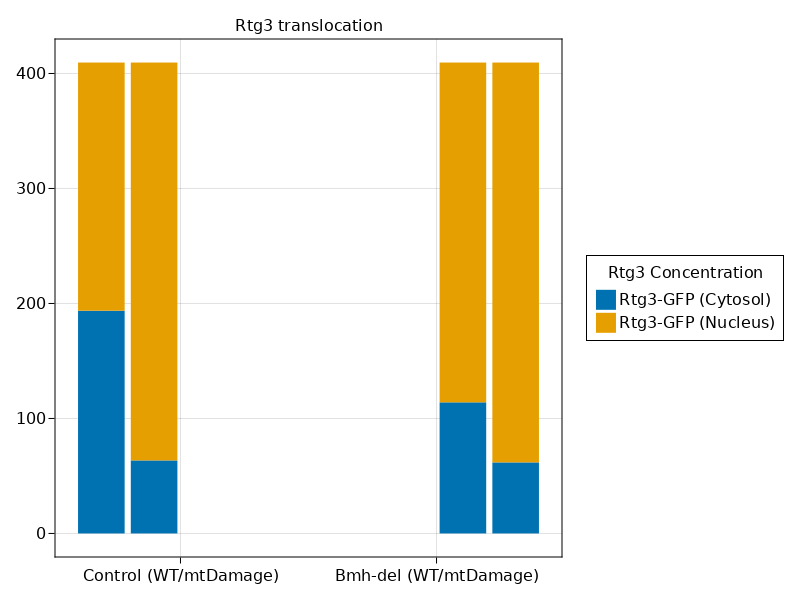

In [154]:
fig = Figure()
colors = Makie.wong_colors()
ax = Axis(fig[1,1], xticks = (1:2, ["Control (WT/mtDamage)", "Bmh-del (WT/mtDamage)"]),
title = "Rtg3 translocation")

barplot!(ax, tbl.x, tbl.height,
        dodge = tbl.grp,
        stack = tbl.grp1,
        color = colors[tbl.grp1]
)

# Legend
labels = ["Rtg3-GFP (Cytosol)", "Rtg3-GFP (Nucleus)"]
elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]
Legend(fig[1,2], elements, labels, "Rtg3 Concentration")
save("validation/img/validation.pdf", fig)
fig